In [1]:
#导入要用的包
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
print("tf version:{}".format(tf.__version__)) #查看一下tensorflow版本


tf version:1.14.0


# 步骤1：加载MNIST数据集


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./mnist\t10k-images-idx3-ubyte.gz
Extracting ./mnist\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
(55000, 784)
(55000, 10)


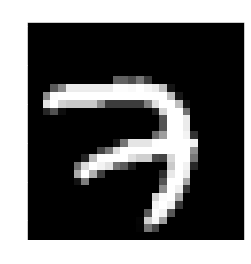

In [2]:
# 导入数据，Tensorflow库中带有MNIST这个数据集
mnist = input_data.read_data_sets('./mnist', one_hot=True)     # 以one_hot方式编码读入数据集,其中图片中的像素值已经做了归一化处理
test_x = mnist.test.images[:2000]   #取测试集的前2000张作为测试
test_y = mnist.test.labels[:2000]

# 将训练集中的第一张图片进行可视化，观测一下数据
print(mnist.train.images.shape)     # 输出训练集的总数量，55000张28*28图片(55000, 28 * 28)
print(mnist.train.labels.shape)   # #图片对应的标签即这张图是数字几 (55000, 10)
plt.imshow(mnist.train.images[0].reshape((28, 28)), cmap='gray')  
plt.title('%i' % np.argmax(mnist.train.labels[0]))
plt.show()

# 步骤2：搭建长短期记忆网络LSTM

In [3]:
tf.set_random_seed(1)
np.random.seed(1)

# 设置好需要用的超参数
BATCH_SIZE = 64
TIME_STEP = 28          # LSTM一次处理的时间长度 / 这里等于图像高度28
INPUT_SIZE = 28         # LSTM的输入维度 / 这里等于图像宽度28
LR = 0.01               # 学习率


tf.reset_default_graph()
# 定义LSTM的输入输出
tf_x = tf.placeholder(tf.float32, [None, TIME_STEP * INPUT_SIZE])       # 输入的维度是(batch, 784)
image = tf.reshape(tf_x, [-1, TIME_STEP, INPUT_SIZE])                   # 转换成LSTM要求的维度
tf_y = tf.placeholder(tf.int32, [None, 10])                             # 输出维度是(batch,10)


#搭建一个LSTM模型，Tensorflow中已经有封装好的函数
lstm_cell = tf.nn.rnn_cell.LSTMCell(num_units=64,reuse=tf.AUTO_REUSE) #设置LSTM中节点数为64
outputs, (h_c, h_n) = tf.nn.dynamic_rnn(
    lstm_cell,                   # 上面搭建的LSTMcell
    image,                      #  输入
    initial_state=None,         # 初始隐状态
    dtype=tf.float32,           #  如果 initial_state = None，需要指定数据类型
    time_major=False,           # False时: (batch, time step, input); True时: (time step, batch, input)
)
output = tf.layers.dense(outputs[:, -1, :], 10)              # 将上面得到的outputs与十个节点进行全连接，十个节点分布表示0-9


loss = tf.losses.softmax_cross_entropy(onehot_labels=tf_y, logits=output)        # 以交叉熵作为预测的损失函数
train_op = tf.train.AdamOptimizer(LR).minimize(loss)  #选择Adam优化器作为优化方法


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# 步骤3：训练LSTM

In [4]:
accuracy = tf.metrics.accuracy(          # 利用tf里的api计算准确率
    labels=tf.argmax(tf_y, axis=1), predictions=tf.argmax(output, axis=1),)[1]

sess = tf.Session()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()) # 初始化所有变量
sess.run(init_op)     # 使上一句初始化语句在计算图中运行

for step in range(150):    # 训练150次
    b_x, b_y = mnist.train.next_batch(BATCH_SIZE)
    _, loss_ = sess.run([train_op, loss], {tf_x: b_x, tf_y: b_y})
    if step % 15 == 0:      # 每训练15次在测试集上测试LSTM的准确率
        accuracy_ = sess.run(accuracy, {tf_x: test_x, tf_y: test_y})
        print('训练误差: %.4f' % loss_, '| 测试准确率: %.2f' % accuracy_)


训练误差: 2.3273 | 测试准确率: 0.12
训练误差: 1.7827 | 测试准确率: 0.28
训练误差: 0.9821 | 测试准确率: 0.38
训练误差: 0.8099 | 测试准确率: 0.45
训练误差: 0.7179 | 测试准确率: 0.51
训练误差: 0.6287 | 测试准确率: 0.55
训练误差: 0.6497 | 测试准确率: 0.59
训练误差: 0.5741 | 测试准确率: 0.62
训练误差: 0.3205 | 测试准确率: 0.64
训练误差: 0.5517 | 测试准确率: 0.66


# 步骤4：使用LSTM进行手写数字预测

In [5]:
test_output = sess.run(output, {tf_x: test_x[:10]}) #对测试集上的前10张图片进行预测
pred_y = np.argmax(test_output, 1)  #test_output是一个list，np.argmax取list中最大数字的下标即预测值。
print(pred_y, '预测值')
print(np.argmax(test_y[:10], 1), '实际值')


[7 2 1 0 4 1 4 9 4 9] 预测值
[7 2 1 0 4 1 4 9 5 9] 实际值


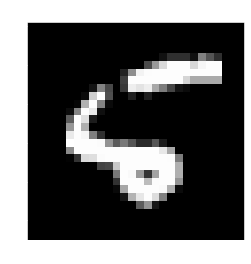

In [6]:
#我们发现第9张图片预测错误，查看一下这张图片
plt.imshow(test_x[8].reshape((28, 28)), cmap='gray')
plt.title('%i' % np.argmax(test_y[8]))
plt.show()